In [1]:
import numpy as np
import scipy.special as ss
import scipy.integrate as si
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import progressbar

In [2]:
# Lattice parameter
a = 10.0

alpha_over_a = 0.1
alpha = alpha_over_a * a
alpha2 = alpha * alpha
alpha3 = alpha2 * alpha
area_per_particle = 0.5 * np.sqrt(3.0) * (a * a)

# Distance between two membranes
h = np.array ([7.0, 10.0, 20.0, 50.0, 100.0]) * alpha

V = 1.0 / (4.0 * np.pi * alpha2) #in units of W_m

S = 1.0 / (4.0 * np.pi * alpha2) #in units of F_m

In [3]:
def sig_tilde_z_0(q, _h):

    chi = 2.0 * q * _h

    chi2 = chi * chi
    q2 = q * q
    e_chi = np.exp(-chi)
    e_2chi = e_chi * e_chi

    f = (-e_2chi + 2.0 * chi * e_chi + 1.0) / (e_2chi - (chi2 + 2.0) * e_chi + 1.0)

    return q * np.exp(-alpha2 * q2) * f

def sig_tilde_z_h (q, _h):
    
    chi = 2.0 * q * _h

    chi2 = chi * chi
    q2 = q * q
    e_chi_2 = np.exp (-0.5 * chi)
    e_chi = e_chi_2 * e_chi_2
    e_2chi = e_chi * e_chi

    f = e_chi_2 * ((chi - 2.0) * e_chi + chi + 2.0) / (e_2chi - (chi2 + 2.0) * e_chi + 1.0)

    return q * np.exp (-alpha2 * q2) * f
    

In [4]:
def v_tilde_z_0 (q, _h):
    
    chi = 2.0 * q * _h
    q2 = q * q
    e_chi = np.exp (-chi)
    e_2chi = e_chi * e_chi
    
    f = (-e_2chi + 2.0 * chi * e_chi + 1.0) / (e_2chi - 2.0 * e_chi + 1.0)
   
    return np.exp (-alpha2 * q2) * f / q

def v_tilde_z_h (q, _h):
    
    chi = 2.0 * q * _h
    chi2 = chi * chi
    q2 = q * q
    e_chi_2 = np.exp (-0.5 * chi)
    e_chi = e_chi_2 * e_chi_2
    e_2chi = e_chi * e_chi

    f = e_chi_2 * ((chi - 2.0) * e_chi + chi + 2.0) / (e_2chi - 2.0 * e_chi + 1.0)
  
    return np.exp (-alpha2 * q2) * f / q

In [5]:
r = np.linspace (0.0, 10.0, 1000) * alpha
r_alpha = r / alpha

bc_v_z_0 = V * np.exp (-r_alpha ** 2 / 4.0)
bc_sig_z_0 = -S * np.exp (-r_alpha ** 2 / 4.0)

In [6]:
def Hankel_Inv (fun, _h, _r):
    
    def integrand(q):

        return fun(q, _h) * ss.jv(0, q * _r) * q

    chunk_interval = 0.01 / alpha
    chunk_interval = 0.1 / alpha
    
    infinity = 100.0
    
    n_chunks = infinity / chunk_interval
    
    result = 0.0
    
    #dres = 1.0
    #dres_old = dres
    n_gauss = 10
    
    #tol = 1.0e-12
    
    #eps_0 = 1.0e-4
    
    m = 0

    #while dres / dres_old > tol:
    while m < n_chunks:
        
        #dres_old = dres
        dres, _ = si.fixed_quad(func=integrand,
                                a= m * chunk_interval, b = (m + 1.0) * chunk_interval,
                                n=n_gauss)

        """dres, _ = si.quadrature(func=integrand,
                                a=float(m) * chunk_interval + eps_0, b=float(m + 1) * chunk_interval + eps_0,
                                rtol=1.0e-10, maxiter=10000)"""
        result += dres

        m += 1

    return result

In [7]:
sig_z_0 = []
sig_z_h = []
v_z_0 = []
v_z_h = []

#q = np.arange (1.0e-4, infty, 0.01)
_inf = 10000.0

for _h in h:
    
    print ("h = ", _h)
    
    I_s0 = []
    I_sh = []
    I_v0 = []
    I_vh = []
    
    bar = progressbar.ProgressBar(max_value=len(r))
    
    i = 0
    
    for _r in r:
        
        I_s0.append (Hankel_Inv (sig_tilde_z_0, _h, _r))
        I_sh.append (Hankel_Inv (sig_tilde_z_h, _h, _r))
        I_v0.append (Hankel_Inv (v_tilde_z_0, _h, _r))
        I_vh.append (Hankel_Inv (v_tilde_z_h, _h, _r))
        
        bar.update (i)
        i += 1
        
    # sig * alpha3 / (eta * W)
    fac = -2.0 * alpha3 * V * 2.0 * alpha2
    
    sz0 = fac * np.array (I_s0)
    szh = fac * np.array (I_sh)
    
    sz0_inf = fac * Hankel_Inv (sig_tilde_z_0, _h, _inf)
    szh_inf = fac * Hankel_Inv (sig_tilde_z_h, _h, _inf)
    
    #sz0_inf = 0.0
    #szh_inf = 0.0
    
    # v * eta * alpha / F
    fac = -0.5 * alpha * (-S) * 2.0 * alpha
    
    vz0 = fac * np.array (I_v0)
    vzh = fac * np.array (I_vh)

    vz0_inf = fac * Hankel_Inv (v_tilde_z_0, _h, _inf)
    vzh_inf = fac * Hankel_Inv (v_tilde_z_h, _h, _inf)
    
    #print (np.trapz (2.0 * np.pi * r * sz0, r))
    
    #sig_z_0.append (sz0 - np.trapz (2.0 * np.pi * r * sz0, r))
    #sig_z_h.append (szh - np.trapz (2.0 * np.pi * r * szh, r))
    
    sig_z_0.append (sz0 - sz0_inf)
    sig_z_h.append (szh - szh_inf)
    
    v_z_0.append (vz0 - vz0_inf)
    v_z_h.append (vzh - vzh_inf)


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

h =  7.0


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

h =  10.0


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

h =  20.0


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

h =  50.0


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

h =  100.0


 99% (999 of 1000) |#################### | Elapsed Time: 0:02:51 ETA:   0:00:00

In [8]:
#for i in range (len (h)):
#    plot (r_alpha, v_z[i])

In [9]:
"""
r_inf = 100

sig_z_0 = []
sig_z_h = []
v_z_0 = []
v_z_h = []

# dimensionless sig * alpha / (eta * v_m)
for _h in h:
    
    sz0 = -4.0 * alpha3 * V * ht.transform(lambda q: sig_tilde_z_0 (q, _h), r, ret_err=False)
    szh = -4.0 * alpha3 * V * ht.transform(lambda q: sig_tilde_z_h (q, _h), r, ret_err=False)

    sz0_inf = -4.0 * alpha3 * V * ht.transform(lambda q: sig_tilde_z_0 (q, _h), r_inf, ret_err=False)
    szh_inf = -4.0 * alpha3 * V * ht.transform(lambda q: sig_tilde_z_h (q, _h), r_inf, ret_err=False)

    vz0 = -alpha * (-S) * ht.transform(lambda q: v_tilde_z_0 (q, _h), r, ret_err=False)
    vzh = -alpha * (-S) * ht.transform(lambda q: v_tilde_z_h (q, _h), r, ret_err=False)
    
    sig_z_0.append (sz0 - sz0_inf)
    sig_z_h.append (szh - szh_inf)
    
    v_z_0.append (vz0)
    v_z_h.append (vzh)"""

'\nr_inf = 100\n\nsig_z_0 = []\nsig_z_h = []\nv_z_0 = []\nv_z_h = []\n\n# dimensionless sig * alpha / (eta * v_m)\nfor _h in h:\n    \n    sz0 = -4.0 * alpha3 * V * ht.transform(lambda q: sig_tilde_z_0 (q, _h), r, ret_err=False)\n    szh = -4.0 * alpha3 * V * ht.transform(lambda q: sig_tilde_z_h (q, _h), r, ret_err=False)\n\n    sz0_inf = -4.0 * alpha3 * V * ht.transform(lambda q: sig_tilde_z_0 (q, _h), r_inf, ret_err=False)\n    szh_inf = -4.0 * alpha3 * V * ht.transform(lambda q: sig_tilde_z_h (q, _h), r_inf, ret_err=False)\n\n    vz0 = -alpha * (-S) * ht.transform(lambda q: v_tilde_z_0 (q, _h), r, ret_err=False)\n    vzh = -alpha * (-S) * ht.transform(lambda q: v_tilde_z_h (q, _h), r, ret_err=False)\n    \n    sig_z_0.append (sz0 - sz0_inf)\n    sig_z_h.append (szh - szh_inf)\n    \n    v_z_0.append (vz0)\n    v_z_h.append (vzh)'

In [10]:
xi = r_alpha ** 2 / 8.0

v_z_0_inf = 1.0 / (8.0 * np.sqrt (np.pi)) * np.exp (-xi) * ss.iv(0, xi)
sig_z_0_inf = - 1.0 / (4.0 * np.sqrt (np.pi)) * np.exp (-xi) * ((1.0 - 2.0 * xi) * ss.iv (0, xi) + 2.0 * xi * ss.iv (1, xi))

In [11]:
mpl.rcParams['xtick.labelsize'] = 42
mpl.rcParams['ytick.labelsize'] = 42

mpl.rcParams['xtick.major.pad'] = 15
mpl.rcParams['ytick.major.pad'] = 8

mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1

mpl.rcParams['ytick.major.size'] = 14
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1

mpl.rc('font',**{'family':'Cabin'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

color_list = ['xkcd:steel blue', 'xkcd:orange red', 'xkcd:gray green', 'xkcd:burgundy', 'xkcd:burnt sienna']
color_gray = (0.4, 0.4, 0.4)
label_font_size = 68
legend_font_size = 52
line_width = 6

<Figure size 432x288 with 0 Axes>

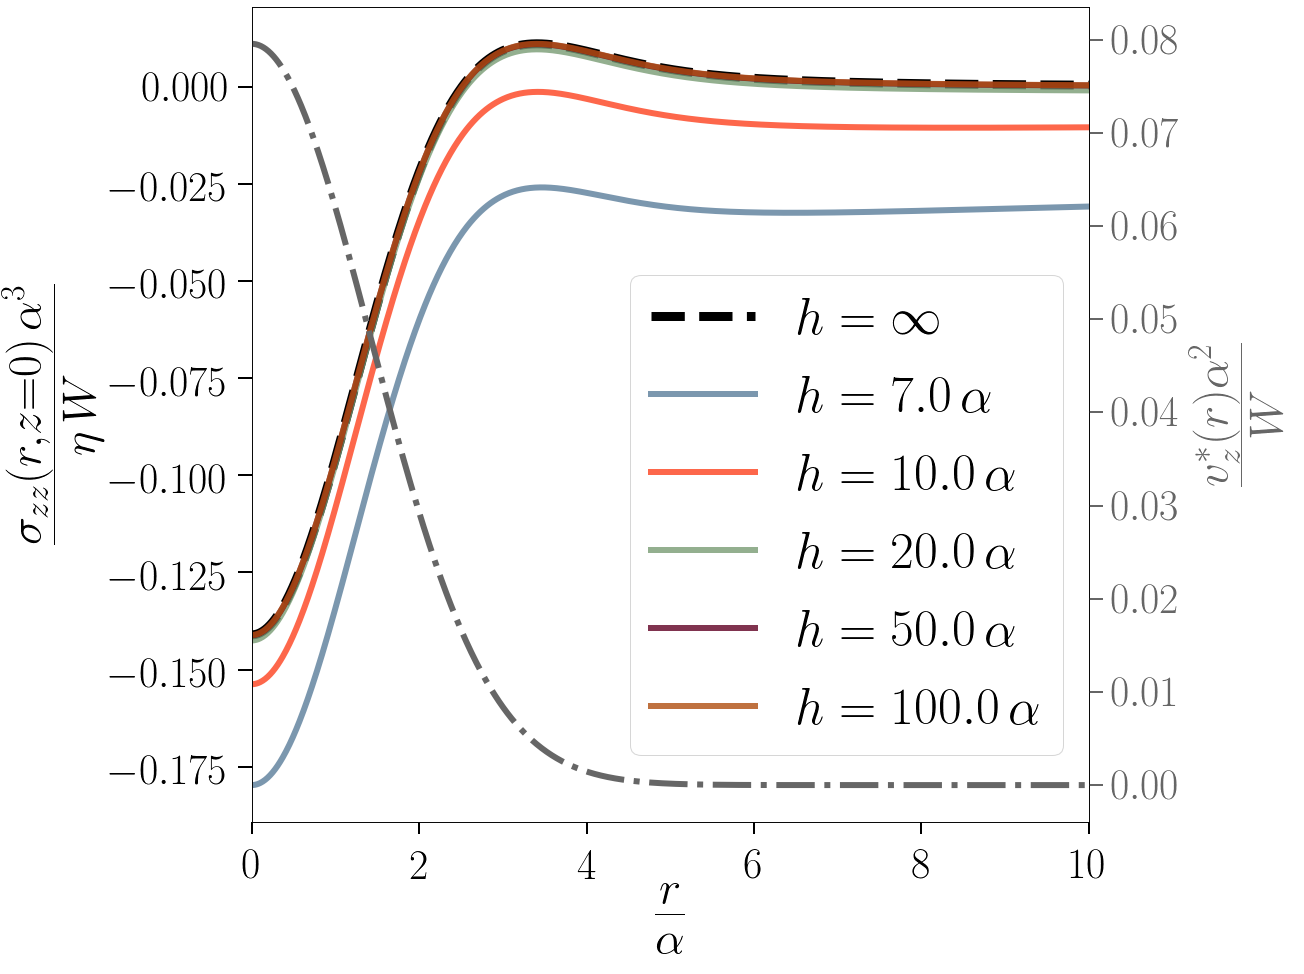

<Figure size 432x288 with 0 Axes>

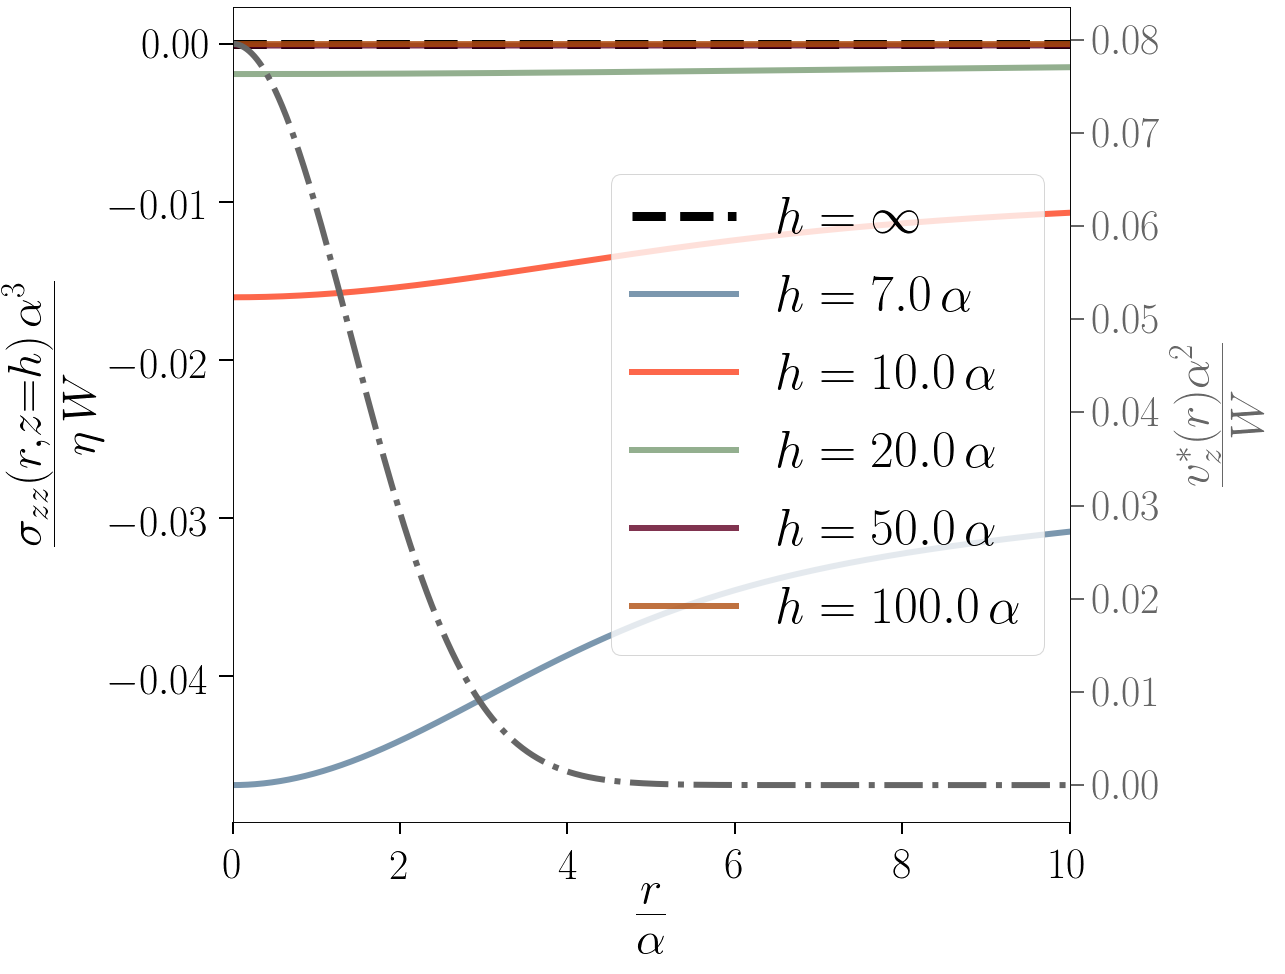

In [12]:
plt.figure ()

fig, ax1 = plt.subplots (figsize = (15, 15))

ax1.plot (r_alpha, sig_z_0_inf, linewidth = 1.5 * line_width, color = 'black', linestyle='--', label = r"$h = \infty$")

for i in range (len (h)):
    ax1.plot (r_alpha, sig_z_0[i], linewidth = line_width, color=color_list[i], label = r"$h = " + str(h[i]/alpha) + r"\,\alpha$", alpha=0.8)

ax1.legend (fontsize = legend_font_size, bbox_to_anchor = (1.0, 0.05), loc=4)

ax1.set_xlabel(r'$\frac{r}{\alpha}$',fontsize = label_font_size, labelpad = 10)
ax1.set_ylabel(r'$\frac{\sigma_{zz}\left(r, z=0 \right) \, \alpha^3}{\eta \, W}$',fontsize = label_font_size, labelpad = 0, color = 'black')
ax1.tick_params('y', colors='black')

ax1.set_xlim (0.0, 10.0)
#ax1.grid(axis='both')

ax2 = ax1.twinx ()

ax2.plot (r_alpha, bc_v_z_0, color = color_gray, linewidth = line_width, linestyle='-.')
ax2.set_ylabel(r'$\frac{v^{*}_{z}\left(r\right) \alpha ^ 2}{W}$',fontsize = label_font_size, labelpad = 25, color = color_gray)
ax2.tick_params('y', colors=color_gray)
ax2.set_xlim (0.0, 10.0)

#plt.savefig(r'/storage/mi/sadeghi/Dropbox/FU Berlin/Results/Hydrodynamic Interaction/parallel_planar_sig_z_0.pdf',
#            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

plt.savefig(r'/srv/public/Dropbox/FU Berlin/Publications/Hydrodynamics and kinetics of membranes/paper_SadeghiNoe_MembraneKinetics_detailed/manuscript_ver_1/figures/planar_parallel_stress_same.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

plt.figure ()

fig, ax1 = plt.subplots (figsize = (15, 15))

ax1.plot (r_alpha, np.zeros_like(r_alpha), linewidth = 1.5 * line_width, color = 'black', linestyle='--', label = r"$h = \infty$")

for i in range (len (h)):
    ax1.plot (r_alpha, sig_z_h[i], linewidth = line_width, color=color_list[i], label = r"$h = " + str(h[i]/alpha) + r"\,\alpha$", alpha = 0.8)


ax1.legend (fontsize = legend_font_size,loc=5)

ax1.set_xlabel(r'$\frac{r}{\alpha}$',fontsize = label_font_size, labelpad = 10)
ax1.set_ylabel(r'$\frac{\sigma_{zz}\left(r, z=h \right) \, \alpha ^ 3}{\eta \, W}$',fontsize = label_font_size,
               labelpad = 0, color = 'black')
ax1.tick_params('y', colors='black')

ax1.set_xlim (0.0, 10.0)
#ax1.grid(axis='both')

ax2 = ax1.twinx ()

ax2.plot (r_alpha, bc_v_z_0, color = color_gray, linewidth = line_width, linestyle='-.')
ax2.set_ylabel(r'$\frac{v^{*}_{z}\left(r\right) \alpha ^ 2}{W}$',fontsize = label_font_size, labelpad = 25, color = color_gray)
ax2.tick_params('y', colors= color_gray)
ax2.set_xlim (0.0, 10.0)

#plt.savefig(r'/storage/mi/sadeghi/Dropbox/FU Berlin/Results/Hydrodynamic Interaction/parallel_planar_sig_z_h.pdf',
#            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

plt.savefig(r'/srv/public/Dropbox/FU Berlin/Publications/Hydrodynamics and kinetics of membranes/paper_SadeghiNoe_MembraneKinetics_detailed/manuscript_ver_1/figures/planar_parallel_stress_cross.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

<Figure size 432x288 with 0 Axes>

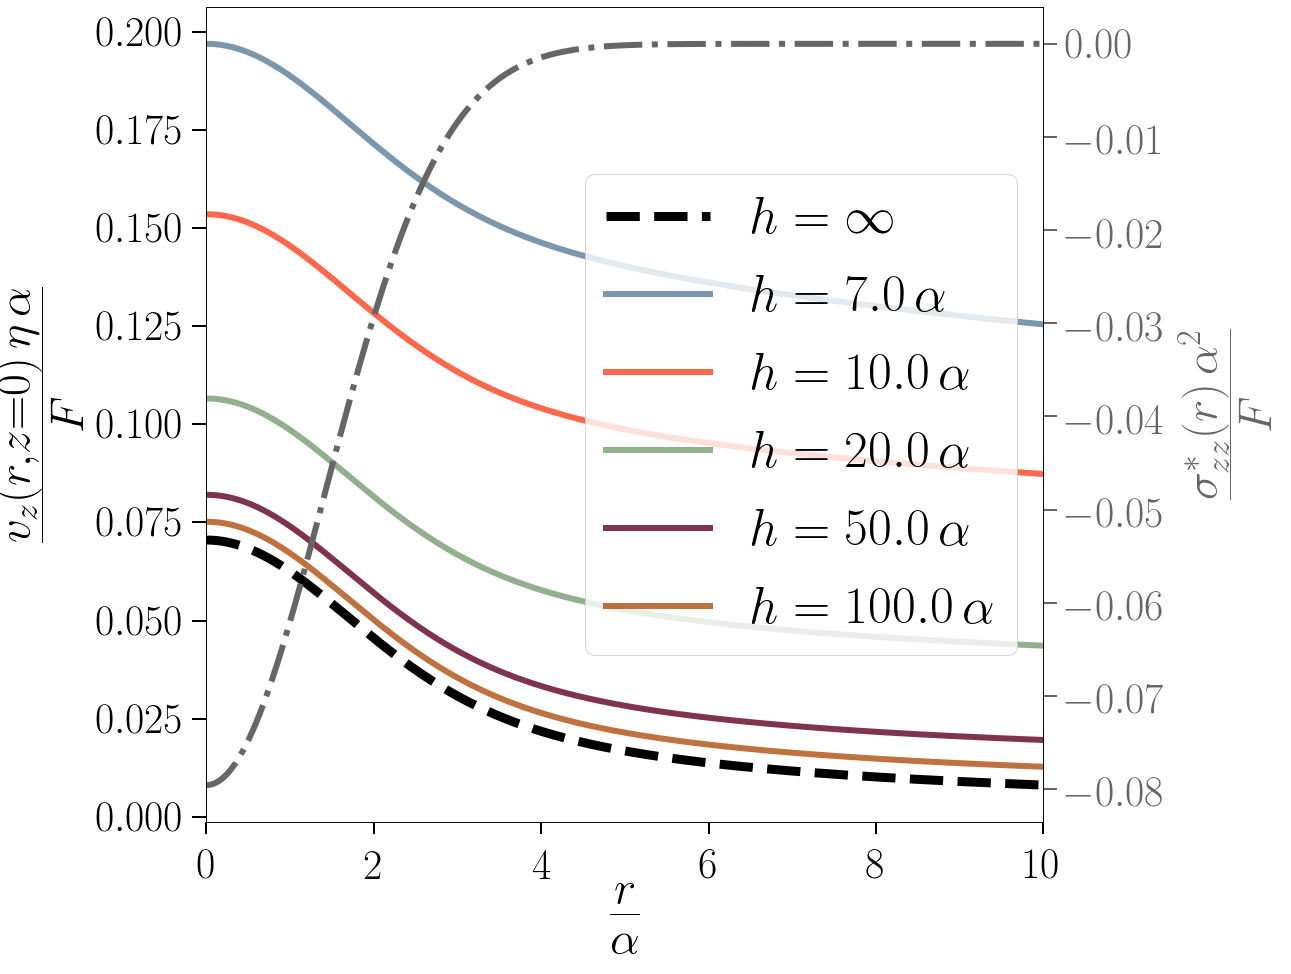

<Figure size 432x288 with 0 Axes>

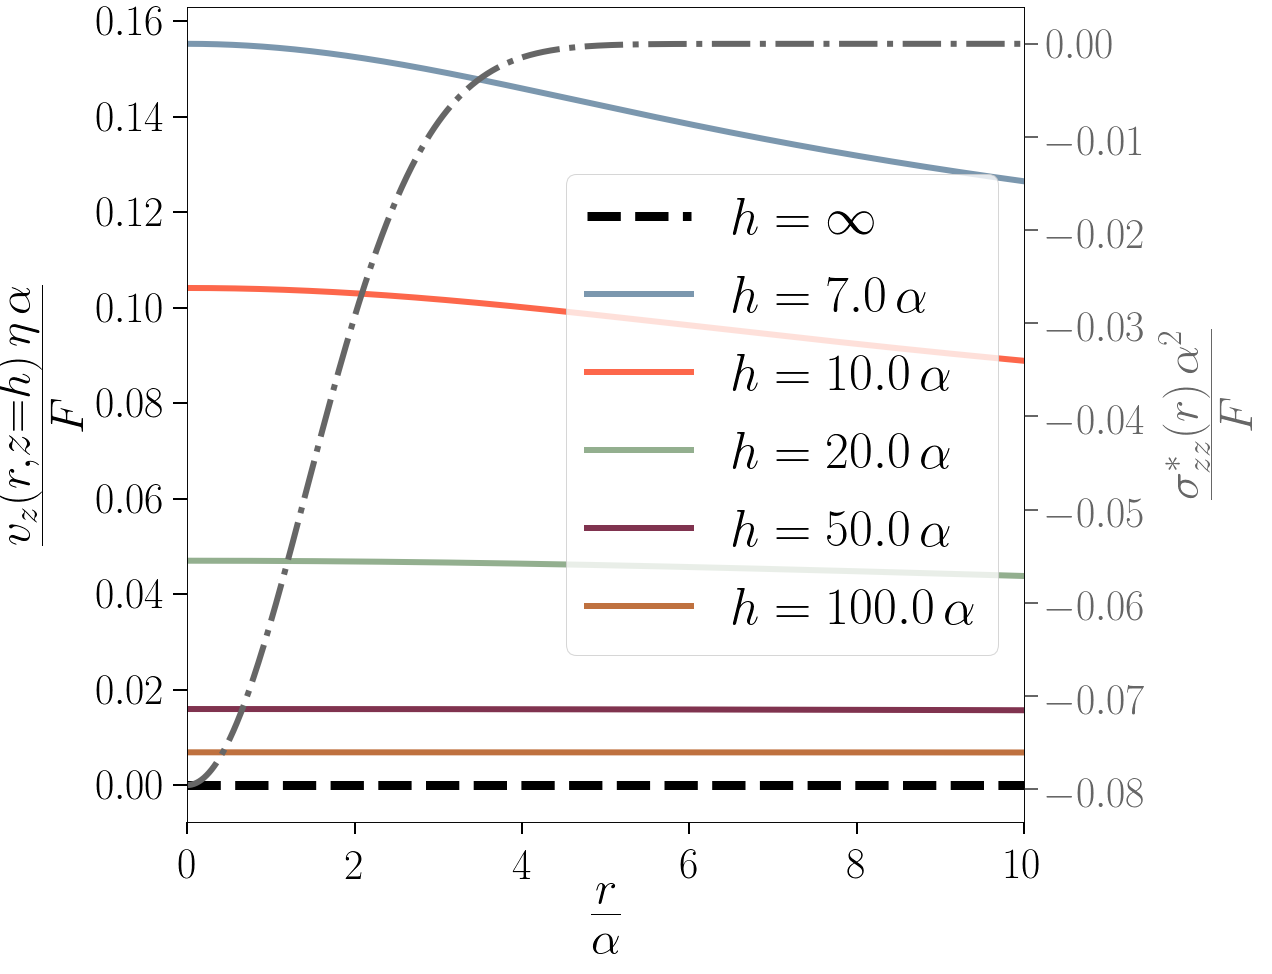

In [13]:
plt.figure ()

fig, ax1 = plt.subplots (figsize = (15, 15))

ax1.plot (r_alpha, v_z_0_inf, linewidth = 1.5 * line_width, linestyle='--', color = 'black', label = r"$h = \infty$")

for i in range (len (h)):
    ax1.plot (r_alpha, v_z_0[i], linewidth = line_width, color=color_list[i], label = r"$h = " + str(h[i]/alpha) + r"\,\alpha$", alpha = 0.8)

ax1.legend (fontsize = legend_font_size,loc=5)

ax1.set_xlabel(r'$\frac{r}{\alpha}$',fontsize = label_font_size, labelpad = 10)
ax1.set_ylabel(r'$\frac{v_{z}\left(r, z=0 \right) \, \eta \, \alpha}{F}$',fontsize = label_font_size, labelpad = 0, color = 'black')
ax1.tick_params('y', colors='black')

ax1.set_xlim (0.0, 10.0)
#ax1.grid(axis='both')

ax2 = ax1.twinx ()

ax2.plot (r_alpha, bc_sig_z_0, color = color_gray, linewidth = line_width, linestyle='-.')
ax2.set_xlabel(r'$\frac{r}{\alpha}$',fontsize = label_font_size, labelpad = 10)
ax2.set_ylabel(r'$\frac{\sigma_{zz}^{*}\left(r\right)\,\alpha^2}{F}$',fontsize = label_font_size, labelpad = 25, color = color_gray)
ax2.tick_params('y', colors=color_gray)
ax2.set_xlim (0.0, 10.0)

#plt.savefig(r'/storage/mi/sadeghi/Dropbox/FU Berlin/Results/Hydrodynamic Interaction/parallel_planar_v_z_0.pdf',
#            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

plt.savefig(r'/srv/public/Dropbox/FU Berlin/Publications/Hydrodynamics and kinetics of membranes/paper_SadeghiNoe_MembraneKinetics_detailed/manuscript_ver_1/figures/planar_parallel_velocity_same.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

plt.figure ()

fig, ax1 = plt.subplots (figsize = (15, 15))

ax1.plot (r_alpha, np.zeros_like(r_alpha), linewidth = 1.5 * line_width, color = 'black', linestyle='--', label = r"$h = \infty$")

for i in range (len (h)):
    ax1.plot (r_alpha, v_z_h[i], linewidth = line_width, color=color_list[i], label = r"$h = " + str(h[i]/alpha) + r"\,\alpha$", alpha = 0.8)

ax1.legend (fontsize = legend_font_size, loc = 5)

ax1.set_xlabel(r'$\frac{r}{\alpha}$',fontsize = label_font_size, labelpad = 10)
ax1.set_ylabel(r'$\frac{v_{z}\left(r, z=h \right)\,\eta \, \alpha}{F}$',fontsize = label_font_size, labelpad = 0, color = 'black')
ax1.tick_params('y', colors='black')

ax1.set_xlim (0.0, 10.0)
#ax1.grid(axis='both')

ax2 = ax1.twinx ()

ax2.plot (r_alpha, bc_sig_z_0, color = color_gray, linewidth = line_width, linestyle='-.')
ax2.set_ylabel(r'$\frac{\sigma_{zz}^{*}\left(r\right)\,\alpha^2}{F}$',fontsize = label_font_size, labelpad = 25, color = color_gray)
ax2.tick_params('y', colors=color_gray)
ax2.set_xlim (0.0, 10.0)

#plt.savefig(r'/storage/mi/sadeghi/Dropbox/FU Berlin/Results/Hydrodynamic Interaction/parallel_planar_v_z_h.pdf',
#            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)

plt.savefig(r'/srv/public/Dropbox/FU Berlin/Publications/Hydrodynamics and kinetics of membranes/paper_SadeghiNoe_MembraneKinetics_detailed/manuscript_ver_1/figures/planar_parallel_velocity_cross.pdf',
            format = 'pdf', bbox_inches='tight', pad_inches = 0.5, transparent = True, dpi = 300)